In [ ]:
!pip install yfinance
!pip install darts
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install pyyaml==5.4.1
!pip install holidays==0.13

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mape, mase, mae, rmse
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mse
plt.style.use('fivethirtyeight')

In [ ]:
BBNI = yf.download(['BBNI.jk'], 
                      start='2015-01-01', 
                      end='2022-01-01', 
                      progress=False).reset_index()

In [ ]:
BBNI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1752 non-null   datetime64[ns]
 1   Open       1752 non-null   float64       
 2   High       1752 non-null   float64       
 3   Low        1752 non-null   float64       
 4   Close      1752 non-null   float64       
 5   Adj Close  1752 non-null   float64       
 6   Volume     1752 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 95.9 KB


In [ ]:
BBNI

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,6050.0,6125.0,6050.0,6100.0,4923.147461,11700700
1,2015-01-05,6075.0,6075.0,6000.0,6025.0,4862.616699,13824800
2,2015-01-06,6000.0,6050.0,5950.0,6025.0,4862.616699,23801400
3,2015-01-07,6000.0,6100.0,5975.0,6075.0,4902.970215,19387800
4,2015-01-08,6100.0,6125.0,6025.0,6075.0,4902.970215,16755600
...,...,...,...,...,...,...,...
1747,2021-12-24,6650.0,6725.0,6575.0,6725.0,6603.161621,13733200
1748,2021-12-27,6725.0,6750.0,6675.0,6750.0,6627.708496,10650300
1749,2021-12-28,6750.0,6775.0,6700.0,6700.0,6578.614258,14716300
1750,2021-12-29,6700.0,6750.0,6675.0,6725.0,6603.161621,8425900


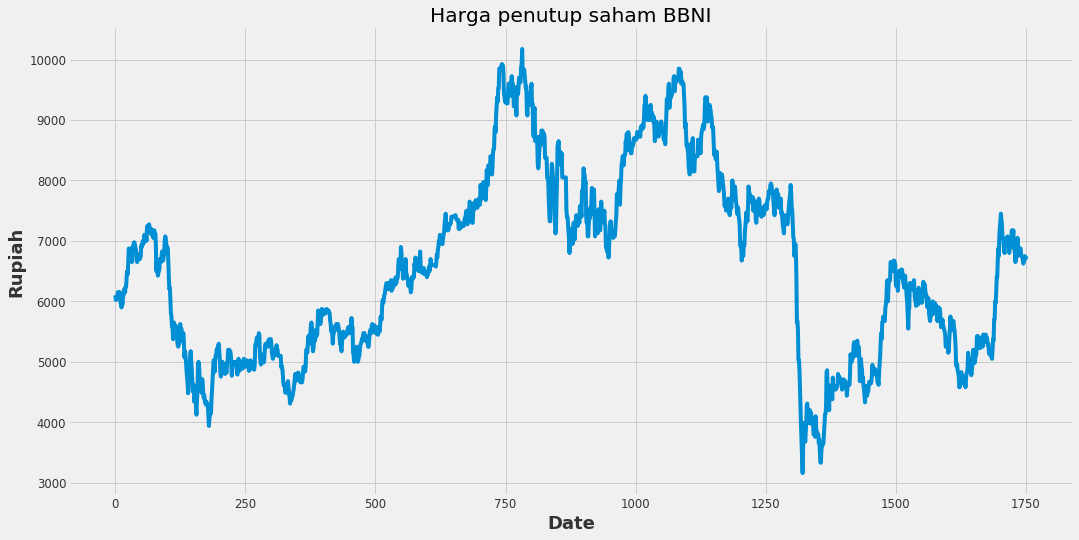

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Harga penutup saham BBNI')
plt.plot(BBNI['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Rupiah',fontsize=18)
plt.show()

In [ ]:
BBNI = BBNI.filter(['Date', 'Close'])

In [ ]:
full_dates = pd.DataFrame(pd.date_range(start = '2015-01-01', end = '2021-12-31', freq = 'D'), columns=['Date'])
data_fill = pd.merge(full_dates, BBNI, how='left', on='Date')
data_fill = data_fill.ffill()
data_fill = data_fill.bfill()
data_fill

,Date,Close
0,2015-01-01,6100.0
1,2015-01-02,6100.0
2,2015-01-03,6100.0
3,2015-01-04,6100.0
4,2015-01-05,6025.0
...,...,...
2552,2021-12-27,6750.0
2553,2021-12-28,6700.0
2554,2021-12-29,6725.0
2555,2021-12-30,6750.0


In [ ]:
BBNI.describe()

,Close
count,1752.000000
mean,6565.296804
std,1539.965557
min,3160.000000
25%,5250.000000
50%,6500.000000
75%,7606.250000
max,10175.000000


In [ ]:
BBNI.isnull().sum()

Date     0
Close    0
dtype: int64

**Skala data yang ideal memiliki jumlah yang relatif kecil**


In [ ]:
skala = (BBNI['Close'].max() - BBNI['Close'].min())*0.01
print(skala)

70.15


In [ ]:
data_ts = TimeSeries.from_dataframe(data_fill, 
                                    time_col = 'Date', 
                                    value_cols = 'Close',
                                    fill_missing_dates=True, freq='d')
scaler_target = Scaler()
data_ts_transformed = scaler_target.fit_transform(data_ts)
train_transformed, val_transformed = data_ts_transformed.split_before(pd.Timestamp('20211216'))

In [ ]:
data_ts

<TimeSeries (DataArray) (Date: 2557, component: 1, sample: 1)>
array([[[6100.]],

       [[6100.]],

       [[6100.]],

       ...,

       [[6725.]],

       [[6750.]],

       [[6750.]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
train_transformed

<TimeSeries (DataArray) (Date: 2541, component: 1, sample: 1)>
array([[[0.41910192]],

       [[0.41910192]],

       [[0.41910192]],

       ...,

       [[0.52601568]],

       [[0.52957947]],

       [[0.52957947]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-15
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
model_TCN = TCNModel(
    input_chunk_length=2330,
    output_chunk_length=15,
    n_epochs=60,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)
model_TCN.fit(train_transformed, past_covariates=None, future_covariates=None, verbose=True)

2022-07-26 05:01:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 197 samples.
2022-07-26 05:01:20 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 9
2022-07-26 05:01:20 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-26 05:01:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-26 05:01:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-26 05:01:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-26 05:01:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-07-26 05:01:20 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

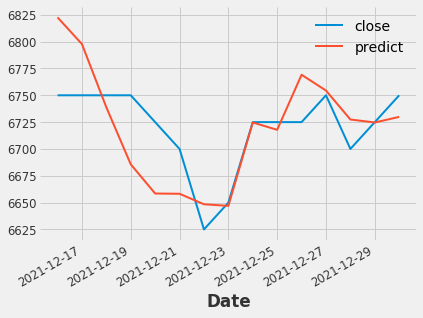

In [ ]:
pred = model_TCN.predict(15, past_covariates=None, num_samples=1)
pred_orig = scaler_target.inverse_transform(pred)

val_orig = scaler_target.inverse_transform(val_transformed)
val_orig.slice_intersect(pred_orig).plot(label='close')

pred_orig.plot(label='predict')
training = scaler_target.inverse_transform(train_transformed)

In [ ]:
mae_score = mae(val_orig, pred_orig)
rmse_score = rmse(val_orig, pred_orig)

print('TCN model MAE is: {}'.format(round(mae_score, 2)))
print('TCN model RMSE is: {}'.format(round(rmse_score)))

TCN model MAE is: 28.97
TCN model RMSE is: 38


In [ ]:
pd.merge(pred_orig.pd_dataframe().rename(columns = {'Close':'Predict'}), val_orig.pd_dataframe(), left_index=True, right_index=True)

component,Predict,Close
Date,,
2021-12-16,6822.609124,6750.0
2021-12-17,6797.721260,6750.0
2021-12-18,6738.785400,6750.0
2021-12-19,6685.702931,6750.0
2021-12-20,6658.474213,6725.0
2021-12-21,6658.230899,6700.0
2021-12-22,6648.450011,6625.0
2021-12-23,6646.964266,6650.0
2021-12-24,6724.646452,6725.0
